## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import random
import datetime

import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
%matplotlib inline

import tensorboard
%load_ext tensorboard

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

import albumentations
from ImageDataAugmentor.image_data_augmentor import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [2]:
try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *

## 1. Preparation

In this notebook we start to train several models for classification. We will try the following approaches:
* create our own architecture from scratch using several CNN layers;
* import a pre-trained model and finetune it to solve our specific problem.

### 1.1 Reproducibility

Since we will need to run a several training cycles, and **the training** algorithm of the Neural Networks **might be time-consuming**, it is quite reasonable to use a GPU instance for such purposes. However, we can run this notebook also locally, but it will take much longer.

Therefore, I made different steps for data preparation depending on where you are going to run this notebook:
* on Google Colab;
* locally.

So, if you want to run it on Colab, you should go through all the steps in the relating section and do not touch the steps prepared for local usage. And vice versa.

### 1.2 Running on Google Colab

>**Note:** Execute this steps only if you want to use Colab instance.

In [ ]:
! wget http://cnrpark.it/dataset/CNR-EXT_FULL_IMAGE_1000x750.tar --directory-prefix=data/raw
! tar -xvf "data/raw/CNR-EXT_FULL_IMAGE_1000x750.tar" -C "data/raw"
! wget http://cnrpark.it/dataset/CNR-EXT-Patches-150x150.zip --directory-prefix=data/raw
! unzip "data/raw/CNR-EXT-Patches-150x150.zip" -d "data/raw"
! wget http://cnrpark.it/dataset/CNRPark+EXT.csv --directory-prefix=data/raw

In [ ]:
DATA_DIR = 'data'
RAW_DATA = f'{DATA_DIR}/raw'
PROCESSED_DATA = f'{DATA_DIR}/processed'
TRAIN_DIR = f'{PROCESSED_DATA}/train'
VAL_DIR = f'{PROCESSED_DATA}/val'
TEST_DIR = f'{PROCESSED_DATA}/test'
MODEL_DIR = 'models'
LOG_DIR = 'logs'
IMAGE_WIDTH = 150 # image width
IMAGE_HEIGHT = 150 # image height
IMAGE_CHANNELS = 3 # image channels count
BATCH_SIZE = 32 # batch size
SEED = 42 # used to fix random_state

In [ ]:
column_names = ['image_path', 'class']
train_df = pd.read_csv(f'{RAW_DATA}/LABELS/train.txt', sep=' ', names=column_names, header=None)
val_df = pd.read_csv(f'{RAW_DATA}/LABELS/val.txt', sep=' ', names=column_names, header=None)
test_df = pd.read_csv(f'{RAW_DATA}/LABELS/test.txt', sep=' ', names=column_names, header=None)

In [ ]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
overall = train_size + val_size + test_size
dataset_parts = {
    'data_type': ['train', 'val', 'test'],
    'count': [train_size, val_size, test_size],
    'part': [round(train_size / overall, 2), round(val_size / overall, 2), round(test_size / overall, 2)]
}
dataset_parts_df = pd.DataFrame.from_dict(dataset_parts)
dataset_parts_df

In [ ]:
dataset_parts = ['train', 'val', 'test']
class_names = ['empty', 'occupied']

for part in dataset_parts:
    for class_name in class_names:
        os.makedirs(os.path.join(PROCESSED_DATA, part, class_name), exist_ok=True, mode=0o777)

In [ ]:
train_df['class'] = train_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')
val_df['class'] = val_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')
test_df['class'] = test_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')

In [ ]:
def copy_images(df: pd.DataFrame, data_type: str):
    """
    Copies images from source dir to destination.
    """
    for index, row in df.iterrows():
        src = os.path.join(RAW_DATA, 'PATCHES', row['image_path'])
        dest = os.path.join(PROCESSED_DATA, data_type, row['class'])
        shutil.copy(src, dest)

In [ ]:
copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')

### 1.3 Local running

>**Note:** Execute the cell below only if you want to run this notebook on a local desktop or laptop.

In [34]:
DATA_DIR = '../data'
PROCESSED_DATA = f'{DATA_DIR}/processed'
TRAIN_DIR = f'{PROCESSED_DATA}/train'
VAL_DIR = f'{PROCESSED_DATA}/val'
TEST_DIR = f'{PROCESSED_DATA}/test'
MODEL_DIR = '../models'
LOG_DIR = '../logs'
IMAGE_WIDTH = 150 # image width
IMAGE_HEIGHT = 150 # image height
IMAGE_CHANNELS = 3 # image channels count
BATCH_SIZE = 32 # batch size
SEED = 42 # used to fix random_state

## 2. Model from scratch

First of all, we will try to build our model from the scratch. We start with some functions definitions.

### Data generators

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 94493 images belonging to 2 classes.
Found 18647 images belonging to 2 classes.


### Model architecture

In this part we make some preparations:
* write a universal function that builds custom model according to the given parameters;
* add a training procedure for the given model;
* define several useful methods.

In [5]:
def make_model_from_scratch(
    input_shape=(128, 128, 3),
    use_bnorm=False,
    use_inner=False,
    inner_size=0,
    use_dropout=False,
    drop_rate=0.0,
    loss='binary_crossentropy', 
    optimizer='adam',
    model_name=None
):
    """
    Configures custom model from the scratch.
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    
    if use_bnorm:
        x = layers.BatchNormalization()(x)
        
    pool = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(pool)
    
    if use_inner:
        x = layers.Dense(inner_size, activation='relu')(x)
        
    if use_dropout:        
        x = keras.layers.Dropout(drop_rate)(x)
        
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    if model_name is not None:
        model._name = model_name
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [6]:
class CustomCallback(Callback):
    """
    Custom callback to plot learning rate parameter.
    """
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(f'learning_rate: {K.eval(lr_with_decay)}')

In [7]:
def train(model, train_gen, val_gen, epochs, steps_per_epoch, validation_steps):
    """
    Model training routine.
    """
    
    model_type = ('custom_models' if 'custom' in model._name else 'pretrained_models')

    checkpoint = keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, model_type, model._name + '_{epoch:02d}_{val_accuracy:.3f}.h5'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    
    log_dir = f"{LOG_DIR}/{model_type}_fit/{model._name}_{datetime.datetime.now().strftime('%d%m%Y_%H%M')}"
    log_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001
    )
          
    print_lr = CustomCallback()
    
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint, log_tensorboard, reduce_lr, print_lr],
        workers=2
    )
    
    return model, history

In [8]:
def plot_confusion_matrix(model, val_gen):
    """
    Plots classification report and confusion matrix.
    """
    probes = model.predict_generator(val_gen)
    y_pred = probes > 0.5
    y_true = val_gen.classes
    print('Classification report:')
    class_names = ['Empty', 'Occupied']
    print(classification_report(y_true, y_pred, target_names=class_names))
    print('Confusion matrix:')
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

In [9]:
model_scores = pd.DataFrame(
    columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
)

### Base model

We are going to start training with some basic model:
- `Conv2D` layer with the kernal `(3, 3)` and `Relu` activation;
- `Dense` layer on the output `sigmoid` activation.

Also we will take `Adam` optimizer and set the `learning_rate` value to `0.01`. During the training we will correct our learning rate value according to the scheduler (`ReduceLROnPlateau`).

In [10]:
LEARNING_RATE = 0.01
EPOCHS = 10

In [11]:
model_name = 'custom_model_v1'
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
custom_model_v1 = make_model_from_scratch(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
    loss=loss, 
    optimizer=optimizer,
    model_name=model_name
)

In [25]:
custom_model_v1.summary()
custom_model_v1, history_v1 = train(
    model=custom_model_v1, 
    train_gen=train_generator, 
    val_gen=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=int(len(train_generator) / 2),
    validation_steps=int(len(validation_generator) / 2)
)

Model: "custom_model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 175233    
Total params: 176,129
Trainable params: 176,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1476/1476 [==============================] - 243s 164ms/step - loss: 0.4929 - accuracy: 0.7852 - val

Plot the training/validation curves using tensorboard.

In [32]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 18:52:19 ago. (Use '!kill 1400' to kill it.)

The results of our training are below.

In [63]:
score = pd.DataFrame(
    data=[[custom_model_v1._name, 'no', 0.0, 0, EPOCHS, custom_model_v1.optimizer.get_config(), history_v1.history]],
    columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
)
model_scores = pd.concat([model_scores, score])
model_scores

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,scores
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."


Classification report:
              precision    recall  f1-score   support

       Empty       0.78      0.94      0.85      5232
    Occupied       0.97      0.90      0.94     13415

    accuracy                           0.91     18647
   macro avg       0.88      0.92      0.89     18647
weighted avg       0.92      0.91      0.91     18647

Confusion matrix:


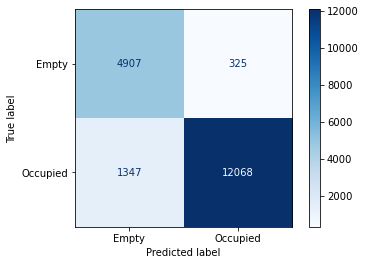

In [40]:
plot_confusion_matrix(custom_model_v1, validation_generator)

### Adding extra inner layer

Next: we will add one inner `Dense` layer and try to tune its `inner_size`.

In [12]:
LEARNING_RATE = 0.005
EPOCHS = 10

Model: "custom_model_v2_innersize_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1752330   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 1,753,237
Trainable params: 1,753,237
Non-trainable params: 0
____________________________

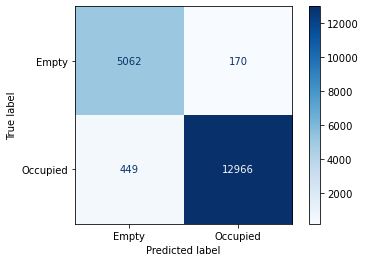



Model: "custom_model_v2_innersize_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                11214912  
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
________________________

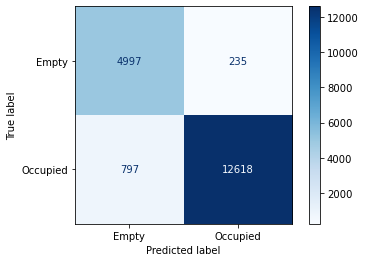



Model: "custom_model_v2_innersize_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 17,524,297
Trainable params: 17,524,297
Non-trainable params: 0
_______________________

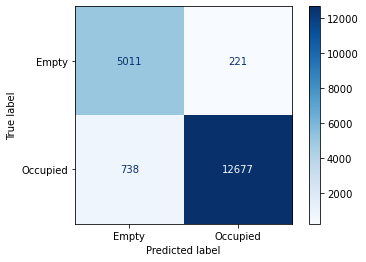

In [65]:
inner_size_list = [10, 64, 100]
for size in inner_size_list:
    model_name = f'custom_model_v2_innersize_{size}'
    loss = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    custom_model_v2 = make_model_from_scratch(
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
        use_inner=True,
        inner_size=size,
        loss=loss, 
        optimizer=optimizer,
        model_name=model_name
    )
    custom_model_v2.summary()

    custom_model_v2, history_v2 = train(
        model=custom_model_v2, 
        train_gen=train_generator, 
        val_gen=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=int(len(train_generator) / 2),
        validation_steps=int(len(validation_generator) / 2)
    )

    score = pd.DataFrame(
        data=[[custom_model_v2._name, 'no', 0.0, size, EPOCHS, custom_model_v2.optimizer.get_config(), history_v2.history]],
        columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
    )
    model_scores = pd.concat([model_scores, score])
    plot_confusion_matrix(custom_model_v2, validation_generator)

    print('\n')

Let's plot the training/validation curves using tensorboard.

In [66]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 1 day, 0:26:19 ago. (Use '!kill 1400' to kill it.)

In [75]:
model_scores

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,score
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."
1,custom_model_v2_innersize_10,no,0.0,10,10,"{'name': 'Adam', 'learning_rate': 0.00125, 'de...","{'loss': [0.26235508918762207, 0.1691731214523..."
2,custom_model_v2_innersize_64,no,0.0,64,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.27350422739982605, 0.1559788286685..."
3,custom_model_v2_innersize_100,no,0.0,100,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.4699958562850952, 0.16336110234260..."


As we can see, loss and accuracy on the validation dataset are better for inner dense layer of the size 100.

### Batch normalization and dropout

Then we will experiment with the `Dropout` layer and its parameter `drop_rate`. Also we can add a [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) layer.

In [13]:
LEARNING_RATE = 0.005
INNER_SIZE = 100
EPOCHS = 15

Model: "custom_model_v3_droprate_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout (Dropout)            (None, 10

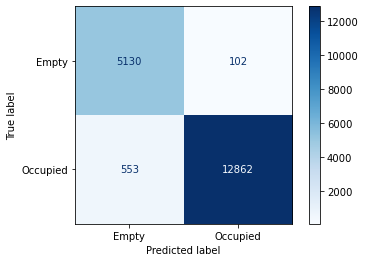



Model: "custom_model_v3_droprate_0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 

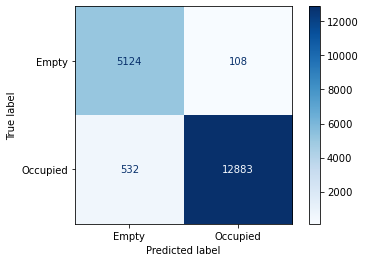



Model: "custom_model_v3_droprate_0.8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_2 (Dropout)          (None, 

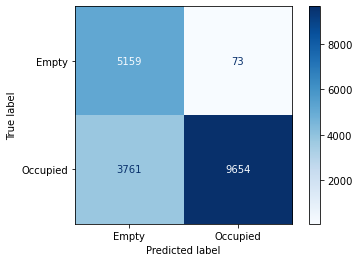

In [77]:
drop_rate_list = [0.2, 0.5, 0.8]
for rate in drop_rate_list:
    model_name = f'custom_model_v3_droprate_{rate}'
    loss = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    custom_model_v3 = make_model_from_scratch(
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
        use_bnorm=True,
        use_inner=True,
        inner_size=INNER_SIZE,
        use_dropout=True,
        drop_rate=rate,
        loss=loss, 
        optimizer=optimizer,
        model_name=model_name
    )
    custom_model_v3.summary()

    custom_model_v3, history_v3 = train(
        model=custom_model_v3, 
        train_gen=train_generator, 
        val_gen=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=int(len(train_generator) / 2),
        validation_steps=int(len(validation_generator) / 2)
    )

    score = pd.DataFrame(
        data=[[custom_model_v3._name, 'yes', rate, INNER_SIZE, EPOCHS, custom_model_v3.optimizer.get_config(), history_v3.history]],
        columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
    )
    model_scores = pd.concat([model_scores, score])
    plot_confusion_matrix(custom_model_v3, validation_generator)

    print('\n')

Plot the loss and accuracy curves as usual.

In [78]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 1 day, 8:50:18 ago. (Use '!kill 1400' to kill it.)

In [79]:
model_scores

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,score
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."
1,custom_model_v2_innersize_10,no,0.0,10,10,"{'name': 'Adam', 'learning_rate': 0.00125, 'de...","{'loss': [0.26235508918762207, 0.1691731214523..."
2,custom_model_v2_innersize_64,no,0.0,64,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.27350422739982605, 0.1559788286685..."
3,custom_model_v2_innersize_100,no,0.0,100,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.4699958562850952, 0.16336110234260..."
0,custom_model_v3_droprate_0.2,yes,0.2,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.6456331014633179, 0.20704907178878..."
0,custom_model_v3_droprate_0.5,yes,0.5,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.7857714295387268, 0.50748330354690..."
0,custom_model_v3_droprate_0.8,yes,0.8,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [1.6413254737854004, 0.67215681076049..."


The optimal value for `drop_rate` is `0.5`.

### Optimizer choosing

Next step: we are going to test several optimizers. There will be:
* [Adam](https://keras.io/api/optimizers/adam/) - a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments;
* [Nadam](https://keras.io/api/optimizers/Nadam/) - is Adam with Nesterov momentum;
* [SGD](https://keras.io/api/optimizers/sgd/) - a gradient descent (with momentum) optimizer.

In [14]:
LEARNING_RATE = 0.001
INNER_SIZE = 100
DROP_RATE = 0.5
EPOCHS = 10

In [15]:
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    'Nadam': keras.optimizers.Nadam(learning_rate=LEARNING_RATE),
    'SGD': keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.8),
}

Model: "custom_model_v4_opt_Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)  

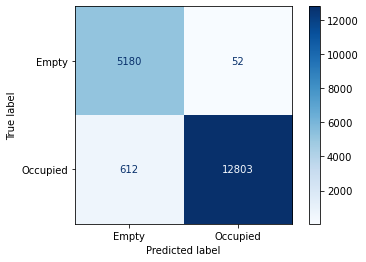



Model: "custom_model_v4_opt_Nadam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_6 (Dropout)          (None, 100

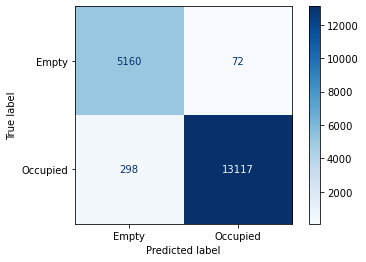



Model: "custom_model_v4_opt_SGD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_7 (Dropout)          (None, 100) 

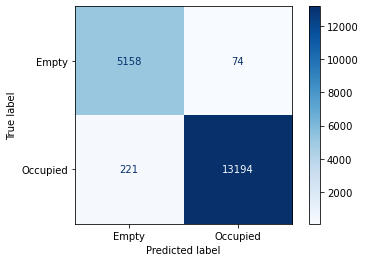

In [92]:
for optimizer in optimizers:
    model_name = f'custom_model_v4_opt_{optimizer}'
    loss = keras.losses.BinaryCrossentropy()
    custom_model_v4 = make_model_from_scratch(
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
        use_bnorm=True,
        use_inner=True,
        inner_size=INNER_SIZE,
        use_dropout=True,
        drop_rate=DROP_RATE,
        loss=loss, 
        optimizer=optimizer,
        model_name=model_name
    )
    custom_model_v4.summary()

    custom_model_v4, history_v4 = train(
        model=custom_model_v4, 
        train_gen=train_generator, 
        val_gen=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=int(len(train_generator) / 2),
        validation_steps=int(len(validation_generator) / 2)
    )

    score = pd.DataFrame(
        data=[[custom_model_v4._name, 'yes', DROP_RATE, INNER_SIZE, EPOCHS, custom_model_v4.optimizer.get_config(), history_v4.history]],
        columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
    )
    model_scores = pd.concat([model_scores, score])
    plot_confusion_matrix(custom_model_v4, validation_generator)

    print('\n')

In [93]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 2 days, 3:47:10 ago. (Use '!kill 1400' to kill it.)

In [94]:
model_scores = model_scores.reset_index(drop=True)
model_scores

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,score
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."
1,custom_model_v2_innersize_10,no,0.0,10,10,"{'name': 'Adam', 'learning_rate': 0.00125, 'de...","{'loss': [0.26235508918762207, 0.1691731214523..."
2,custom_model_v2_innersize_64,no,0.0,64,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.27350422739982605, 0.1559788286685..."
3,custom_model_v2_innersize_100,no,0.0,100,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.4699958562850952, 0.16336110234260..."
4,custom_model_v3_droprate_0.2,yes,0.2,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.6456331014633179, 0.20704907178878..."
5,custom_model_v3_droprate_0.5,yes,0.5,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.7857714295387268, 0.50748330354690..."
6,custom_model_v3_droprate_0.8,yes,0.8,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [1.6413254737854004, 0.67215681076049..."
7,custom_model_v4_opt_Adam,yes,0.5,100,10,"{'name': 'Adam', 'learning_rate': 0.000125, 'd...","{'loss': [0.4058009684085846, 0.15444500744342..."
8,custom_model_v4_opt_Nadam,yes,0.5,100,10,"{'name': 'Nadam', 'learning_rate': 0.000125, '...","{'loss': [0.33522096276283264, 0.1654009073972..."
9,custom_model_v4_opt_SGD,yes,0.5,100,10,"{'name': 'SGD', 'learning_rate': 0.0025, 'deca...","{'loss': [0.16068844497203827, 0.0763876363635..."


`SGD` optimizer shows a slightly better results. So, we will continue to work with it.

Now, let's plot list of misclassifications with actual labels and predictions. May be it helps us to identify some patterns where our model isn't so good.

In [240]:
custom_model_v4 = keras.models.load_model(f'{MODEL_DIR}/custom_models/custom_model_v4_opt_SGD_08_0.990.h5')

In [ ]:
probes = custom_model_v4.predict_generator(validation_generator)
y_pred = probes > 0.5
y_true = validation_generator.classes
incorrect_pred = np.nonzero(y_pred.T[0] != y_true)[0]

In [16]:
def plot_random_wrong_pred(pred_list):
    nrows, ncols = 3, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4 - 1, nrows * 4 - 1))
    for x in range(nrows):
        for y in range(ncols):
            idx = np.random.choice(incorrect_pred)
            batch_idx = idx // BATCH_SIZE
            pos_in_batch = idx % BATCH_SIZE
            axes[x][y].imshow(validation_generator.__getitem__(batch_idx)[0][pos_in_batch - 1]);
            axes[x][y].set_title(f'true label: {y_true[idx]}, prediction: {int(y_pred[idx][0])}')
            axes[x][y].axis('off')

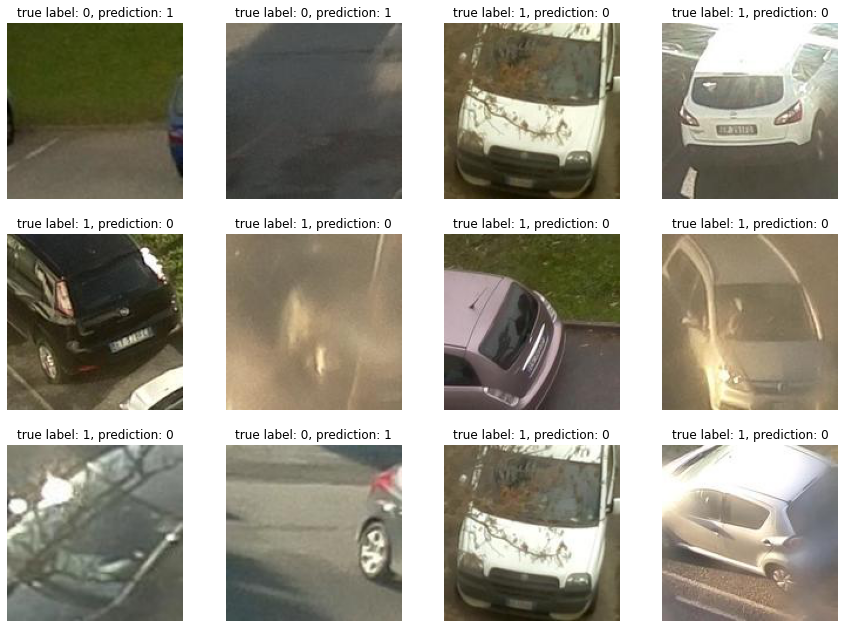

In [150]:
plot_random_wrong_pred(incorrect_pred)

### Data augmentation

Finally, we will try to implement some data augmentation techniques:
- using external [albumentations](https://albumentations.ai/) library;
- standard embedded keras approach.

#### Albumentations

Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance for different computer vision tasks, including object classification, segmentation, and detection.

In [17]:
# List of the augmentations
AUGMENTATIONS = albumentations.Compose([
    # Flips
    albumentations.HorizontalFlip(p=0.25),
#    albumentations.VerticalFlip(p=0.25),
    albumentations.Rotate(limit=30, p=0.2),
    # Color augmentations
    albumentations.OneOf([
        albumentations.HueSaturationValue(p=1.),
        albumentations.RandomBrightnessContrast(p=1.),
        albumentations.RGBShift(p=1.)
    ], p=0.25),
    # Image quality
    albumentations.OneOf([
        albumentations.GaussNoise(p=1.),
        albumentations.MultiplicativeNoise(p=1.),
        albumentations.JpegCompression(p=1.),
        albumentations.Downscale(scale_min=0.5,scale_max=0.99, p=1),
        albumentations.Blur(p=1.0),
    ], p=0.5),
    # Others
    albumentations.ToGray(p=0.1),
])

In this case we are going to use `ImageDataAugmentor` as a dataloader instead of `ImageDataGenerator`. This will allow us to apply the necessary augmentations from Albumentation library without any problems.

In [19]:
# Dataloaders
dg = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED,)

train_generator = dg.flow_from_directory(
    f'{PROCESSED_DATA}/train',
    class_mode='binary',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = dg.flow_from_directory(
    f'{PROCESSED_DATA}/val',
    class_mode='binary', 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 94493 images belonging to 2 classes.
Found 18647 images belonging to 2 classes.


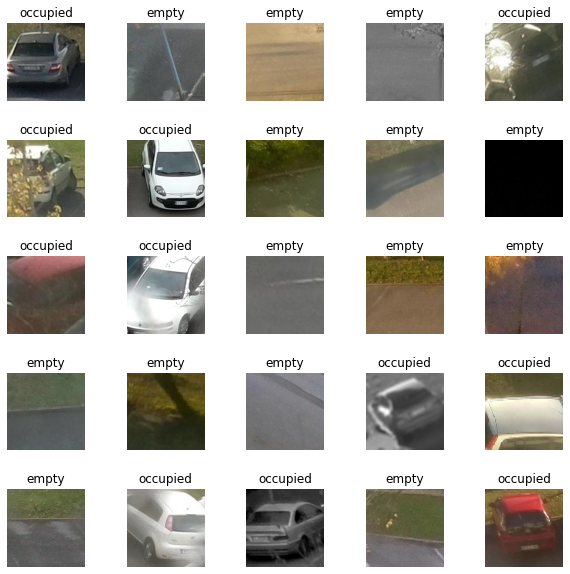

In [22]:
# Visualize some augmented data
train_generator.show_data()

We will train the model with the architecture and optimizer obtained in the previous step on augmented data.

In [21]:
LEARNING_RATE = 0.005
INNER_SIZE = 100
DROP_RATE = 0.5
EPOCHS = 10

Model: "custom_model_v5_aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_52 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_56 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)       

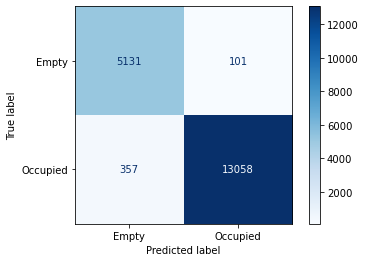

In [218]:
model_name = f'custom_model_v5_aug'
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.8, nesterov=True)
loss = keras.losses.BinaryCrossentropy()
custom_model_v5 = make_model_from_scratch(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
    use_bnorm=True,
    use_inner=True,
    inner_size=INNER_SIZE,
    use_dropout=True,
    drop_rate=DROP_RATE,
    loss=loss, 
    optimizer=optimizer,
    model_name=model_name
)
custom_model_v5.summary()

custom_model_v5, history_v5 = train(
        model=custom_model_v5, 
        train_gen=train_generator, 
        val_gen=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=int(len(train_generator) / 2),
        validation_steps=int(len(validation_generator) / 2)
)

score = pd.DataFrame(
    data=[[custom_model_v5._name, 'yes', DROP_RATE, INNER_SIZE, EPOCHS, custom_model_v5.optimizer.get_config(), history_v5.history]],
    columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'score']
)
model_scores = pd.concat([model_scores, score])
plot_confusion_matrix(custom_model_v5, validation_generator)

In [237]:
model_scores.reset_index(drop=True)

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,score
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."
1,custom_model_v2_innersize_10,no,0.0,10,10,"{'name': 'Adam', 'learning_rate': 0.00125, 'de...","{'loss': [0.26235508918762207, 0.1691731214523..."
2,custom_model_v2_innersize_64,no,0.0,64,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.27350422739982605, 0.1559788286685..."
3,custom_model_v2_innersize_100,no,0.0,100,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.4699958562850952, 0.16336110234260..."
4,custom_model_v3_droprate_0.2,yes,0.2,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.6456331014633179, 0.20704907178878..."
5,custom_model_v3_droprate_0.5,yes,0.5,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.7857714295387268, 0.50748330354690..."
6,custom_model_v3_droprate_0.8,yes,0.8,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [1.6413254737854004, 0.67215681076049..."
7,custom_model_v4_opt_Adam,yes,0.5,100,10,"{'name': 'Adam', 'learning_rate': 0.000125, 'd...","{'loss': [0.4058009684085846, 0.15444500744342..."
8,custom_model_v4_opt_Nadam,yes,0.5,100,10,"{'name': 'Nadam', 'learning_rate': 0.000125, '...","{'loss': [0.33522096276283264, 0.1654009073972..."
9,custom_model_v4_opt_SGD,yes,0.5,100,10,"{'name': 'SGD', 'learning_rate': 0.0025, 'deca...","{'loss': [0.16068844497203827, 0.0763876363635..."


In [193]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 2 days, 15:49:49 ago. (Use '!kill 1400' to kill it.)

This approach hasn't improved our perfomance. Therefore, we should try another one.

#### Keras standard augmentation

Now we will take model with the same architecture and optimizer as before, and try to apply standard Keras augmentations. But we will not perform the full train from the beginning, we will just try to apply additinal training on augmented data (as we did in the homework).

In [23]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5,1.5),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    f'{PROCESSED_DATA}/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 94493 images belonging to 2 classes.


In [294]:
custom_model_v6 = keras.models.load_model(f'{MODEL_DIR}/custom_models/custom_model_v4_opt_SGD_08_0.990.h5')

In [295]:
custom_model_v6.optimizer.learning_rate = 0.0025
custom_model_v6.optimizer.momentum = 0.8
custom_model_v6.optimizer.nesterov = 'True'
custom_model_v6.__name = 'custom_model_v4_opt_SGD_aug'

In [296]:
custom_model_v6.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.0025,
 'decay': 0.0,
 'momentum': 0.8,
 'nesterov': 'True'}

In [24]:
EPOCHS = 5 # Additional 5 training epochs

Model: "custom_model_v4_opt_SGD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)   

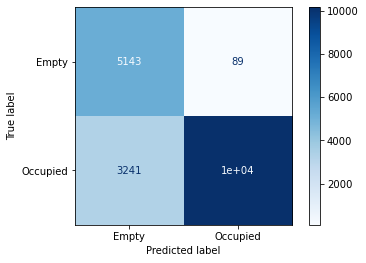

In [298]:
custom_model_v6.summary()

custom_model_v6, history_v6 = train(
        model=custom_model_v6, 
        train_gen=train_generator_aug, 
        val_gen=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=int(len(train_generator_aug) / 2),
        validation_steps=int(len(validation_generator) / 2)
)

score = pd.DataFrame(
    data=[[custom_model_v6._name, 'yes', DROP_RATE, INNER_SIZE, 10 + EPOCHS, custom_model_v6.optimizer.get_config(), history_v6.history]],
    columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'score']
)
model_scores = pd.concat([model_scores, score])
plot_confusion_matrix(custom_model_v6, validation_generator)

In [299]:
%tensorboard --logdir $LOG_DIR/custom_model_fit

Reusing TensorBoard on port 6006 (pid 1400), started 2 days, 22:03:19 ago. (Use '!kill 1400' to kill it.)

In [300]:
model_scores

,model_name,batch_norm,drop_rate,inner_layer_size,epochs,optimizer,score
0,custom_model_v1,no,0.0,0,10,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...","{'loss': [0.49287790060043335, 0.4005536735057..."
1,custom_model_v2_innersize_10,no,0.0,10,10,"{'name': 'Adam', 'learning_rate': 0.00125, 'de...","{'loss': [0.26235508918762207, 0.1691731214523..."
2,custom_model_v2_innersize_64,no,0.0,64,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.27350422739982605, 0.1559788286685..."
3,custom_model_v2_innersize_100,no,0.0,100,10,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.4699958562850952, 0.16336110234260..."
4,custom_model_v3_droprate_0.2,yes,0.2,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.6456331014633179, 0.20704907178878..."
5,custom_model_v3_droprate_0.5,yes,0.5,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [0.7857714295387268, 0.50748330354690..."
6,custom_model_v3_droprate_0.8,yes,0.8,100,15,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...","{'loss': [1.6413254737854004, 0.67215681076049..."
7,custom_model_v4_opt_Adam,yes,0.5,100,10,"{'name': 'Adam', 'learning_rate': 0.000125, 'd...","{'loss': [0.4058009684085846, 0.15444500744342..."
8,custom_model_v4_opt_Nadam,yes,0.5,100,10,"{'name': 'Nadam', 'learning_rate': 0.000125, '...","{'loss': [0.33522096276283264, 0.1654009073972..."
9,custom_model_v4_opt_SGD,yes,0.5,100,10,"{'name': 'SGD', 'learning_rate': 0.0025, 'deca...","{'loss': [0.16068844497203827, 0.0763876363635..."


This model performs even worse than the previous one.

### Testing models

Let's evaluate our models.

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
    f'{PROCESSED_DATA}/test',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 31825 images belonging to 2 classes.


In [231]:
model = keras.models.load_model(f'{MODEL_DIR}/custom_models/custom_model_v4_opt_SGD_08_0.990.h5')

In [232]:
custom_model_v4_opt_SGD_score = model.evaluate(test_generator)

995/995 [==============================] - 196s 197ms/step - loss: 0.0661 - accuracy: 0.9829 - loss: 0.067 - ETA: 0s - loss: 0.0664 - accu


In [26]:
test_generator = dg.flow_from_directory(
    f'{PROCESSED_DATA}/test',
    class_mode='binary', 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 31825 images belonging to 2 classes.


In [226]:
model = custom_model_v5

In [227]:
custom_model_score = model.evaluate(test_generator)

995/995 [==============================] - 237s 238ms/step - loss: 0.0674 - accuracy: 0.9764


## 3. Pretrained model

Now, let's try to import pretrained `Xception` model and finetune it on the augmented data.

### Data generators

In [27]:
train_datagen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
#    shear_range=0.2,
    zoom_range=0.2,
#    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 94493 images belonging to 2 classes.
Found 18647 images belonging to 2 classes.


Plot some results of the augmentantion.

In [28]:
def get_samples_from_datagen(data):
    x = data.next() # Fetch the first batch
    a = x[0] # Image
    b = x[1] # Label
    for i in range(0, 5):
        plt.imshow(a[i])
        plt.title(f'true label: {b[i]}')
        plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


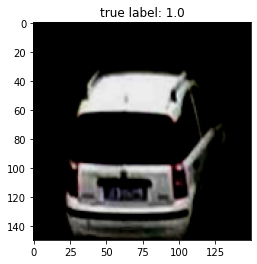

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


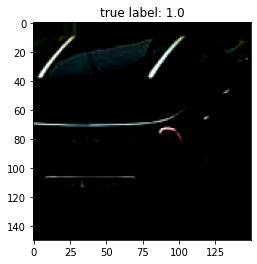

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


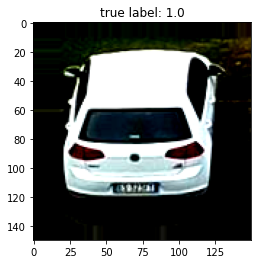

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


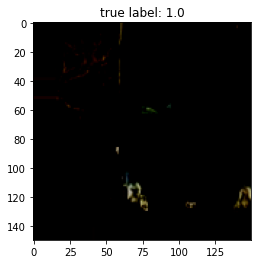

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


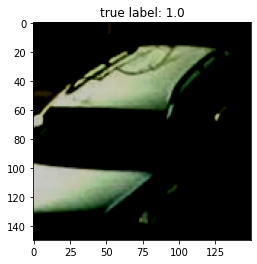

In [29]:
get_samples_from_datagen(train_generator_aug)

In [31]:
def use_pretrained_model(
    base_model,
    input_shape=(128, 128, 3),
    use_inner=False,
    inner_size=0,
    use_dropout=False,
    drop_rate=0.0,
    loss='binary_crossentropy', 
    optimizer='adam',
    model_name=None
):
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(base)
    
    if use_inner:
        x = layers.Dense(inner_size, activation='relu')(x)
        
    if use_dropout:        
        x = layers.Dropout(drop_rate)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    if model_name is not None:
        model._name = model_name
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [32]:
LEARNING_RATE = 0.005
INNER_SIZE = 100
DROP_RATE = 0.5
EPOCHS = 15

In [ ]:
model_name = 'Xception_model_aug'
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.8, nesterov=True)

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
)
base_model.trainable = False

xception_model = use_pretrained_model(
    base_model=base_model,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    use_inner=True,
    inner_size=INNER_SIZE,
    use_dropout=True,
    drop_rate=DROP_RATE,
    loss=loss, 
    optimizer=optimizer,
    model_name=model_name
)
xception_model.summary()

xception_model, xception_history = train(
    model=xception_model, 
    train_gen=train_generator_aug, 
    val_gen=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=int(len(train_generator_aug) / 2),
    validation_steps=int(len(validation_generator) / 2)
)

plot_confusion_matrix(xception_model, validation_generator)

I ran this model training on Google Colab. Therefore, I wold like to left a screenshot with training progress here.

In [32]:
Image(url= "xception_training.png")

In [4]:
score = pd.DataFrame(
    data=[[xception_model._name, 'no', DROP_RATE, INNER_SIZE, EPOCHS, xception_model.optimizer.get_config(), xception_history.history]],
    columns = ['model_name', 'batch_norm', 'drop_rate', 'inner_layer_size', 'epochs', 'optimizer', 'scores']
)
model_scores = pd.concat([model_scores, score])

In [ ]:
model_scores = model_scores.reset_index(drop=True)
model_scores

In [ ]:
%tensorboard --logdir $LOG_DIR/pretrained_models_fit

Now, let's test our model.

In [35]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 31825 images belonging to 2 classes.


In [ ]:
xception_model.evaluate(test_generator)

The pretrained `Xception` model showed the best results. So, we will pick it.